In [2]:
import pandas as pd
import numpy as np
import re

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
data_1 = pd.read_csv('bina_az_02102023.csv')
data_2 = pd.read_csv('bina_az_new.csv')
data_3 = pd.read_csv('bina_az_old.csv')
data_4 = pd.read_csv('bina_az_25102023.csv')
frames = pd.concat([data_1, data_2,data_3,data_4], copy=False,ignore_index=True)
frames = frames.reset_index(drop=True)
frames=frames.drop_duplicates(keep='last')
frames=frames.dropna(ignore_index=True)

In [4]:
frames.tail()

,id,link,view,updated,title,seller_type,price,currency,description,category,flat_number,area,room_count,documents,is_repair
46497,Elanın nömrəsi: 3835466,https://bina.az/items/3835466,"Yeniləndi: 16 Oktyabr 2023 ,Baxışların sayı: 243",Yeniləndi: 16 Oktyabr 2023,"Satılır 3 otaqlı köhnə tikili 45 m², 20 Yanvar m.",vasitəçi (agent),106 000,AZN,20 yanvar m/s cixisinda 5 mertebeli binanin 1 ...,Köhnə tikili,1 / 5,45 m²,3,var,var
46498,Elanın nömrəsi: 3817086,https://bina.az/items/3817086,"Yeniləndi: 16 Oktyabr 2023 ,Baxışların sayı: 587",Yeniləndi: 16 Oktyabr 2023,"Satılır 4 otaqlı köhnə tikili 127 m², Səbail r.",vasitəçi (agent),256 000,AZN,Təcili satılır!!! BAKI ŞƏHƏRİNİN ELİT ƏRAZİLƏR...,Köhnə tikili,7 / 9,127 m²,4,var,var
46499,Elanın nömrəsi: 3847448,https://bina.az/items/3847448,"Yeniləndi: 16 Oktyabr 2023 ,Baxışların sayı: 66",Yeniləndi: 16 Oktyabr 2023,"Satılır 2 otaqlı köhnə tikili 50 m², Neftçilər m.",vasitəçi (agent),110 000,AZN,"Nizami rayonu,Rüstəm Rüstəmov küçəsi,Neftçilər...",Köhnə tikili,5 / 5,50 m²,2,var,var
46500,Elanın nömrəsi: 3847609,https://bina.az/items/3847609,"Yeniləndi: 16 Oktyabr 2023 ,Baxışların sayı: 142",Yeniləndi: 16 Oktyabr 2023,"Satılır 2 otaqlı köhnə tikili 45 m², 8 Noyabr m.",vasitəçi (agent),86 000,AZN,"KUPÇALI!\n,TƏCİLİ!+DUSMƏ QİYMƏTƏ!\n,3-cü mikro...",Köhnə tikili,2 / 5,45 m²,2,var,var
46501,Elanın nömrəsi: 3847817,https://bina.az/items/3847817,"Yeniləndi: 16 Oktyabr 2023 ,Baxışların sayı: 135",Yeniləndi: 16 Oktyabr 2023,"Satılır 4 otaqlı köhnə tikili 100 m², Hövsan q.",vasitəçi (agent),98 000,AZN,Hövsan PEKARNİNİN yanında 5/5 mərtəbə 4/3 otağ...,Köhnə tikili,5 / 5,100 m²,4,var,var


## is_near_metro

In [5]:
frames['is_near_metro'] = (frames['description'].str.contains('m\.', case=False)|frames['description'].str.contains('metro', case=False)).astype(int)

## Seller type

In [6]:
frames = frames.drop(frames[frames['seller_type'] == 'seller_type'].index)
frames['seller_type_encoded'] = frames['seller_type'].replace({'mülkiyyətçi': 1 ,'vasitəçi (agent)': 0 })

## Category

In [7]:
frames['category_encoded'] = frames['category'].replace({'Yeni tikili': 1, 'Köhnə tikili': 0})

## Flat

In [8]:
frames[['flat', 'total_flat']] = frames['flat_number'].str.split(' / ', expand=True).astype(int)

## Area

In [9]:
def remove_non_numeric_and_convert_to_float(value):
    numeric_part = re.sub(r'[^\d.]', '', value)
    if numeric_part:
        return float(numeric_part)
    else:
        return None
frames['area_converted'] = frames['area'].apply(remove_non_numeric_and_convert_to_float)

## Room count

In [10]:
frames['room_count'] = frames['room_count'].astype(int)

## Document

In [11]:
frames['documents_encoded'] = frames['documents'].replace({'var': 1, 'yoxdur': 0})

## Is repaired

In [12]:
frames['is_repair_encoded'] = frames['is_repair'].replace({'var': 1, 'yoxdur': 0})

## Price and Currency

In [13]:
frames['price'] = frames['price'].str.replace(' ', '', regex=True)
frames['price'] = frames['price'].astype(int)

In [14]:
frames['currency'].unique()

array(['AZN'], dtype=object)

## Feature selection

In [15]:
frames.columns

Index(['id', 'link', 'view', 'updated', 'title', 'seller_type', 'price',
       'currency', 'description', 'category', 'flat_number', 'area',
       'room_count', 'documents', 'is_repair', 'is_near_metro',
       'seller_type_encoded', 'category_encoded', 'flat', 'total_flat',
       'area_converted', 'documents_encoded', 'is_repair_encoded'],
      dtype='object')

In [16]:
frames=frames[['seller_type_encoded','flat','total_flat','room_count','area_converted', 'category_encoded' , 'documents_encoded' ,'is_repair_encoded' ,'is_near_metro','price']].drop_duplicates(ignore_index=True)

## Modelling

In [17]:
data = frames
X = data.drop(columns=['price'])
y = data['price'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,  
    max_depth=3,
    objective='reg:squarederror')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print("Model perforamnce metrics")
print("-----------------------")
print(f"R-squared: {r2:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print("-----------------------")

Model perforamnce metrics
-----------------------
R-squared: 0.71
Root Mean Squared Error: 94692.87
Mean Absolute Error: 47724.29
-----------------------


## Deployment from actual dataframe

In [18]:
data = frames

def train_xgboost_model(data):
    X = data.drop(columns=['price'])  
    y = data['price'] 
    model = xgb.XGBRegressor(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        objective='reg:squarederror')
    model.fit(X, y)
    return model

def deploy_first_row(model, data):
    first_row = data.iloc[0]
    actual_price = first_row['price']
    prediction_data = first_row.drop(['price']).to_frame().T
    predicted_price = model.predict(prediction_data)
    predicted_price = predicted_price[0]
    return actual_price, predicted_price
trained_model = train_xgboost_model(data)
actual_price, predicted_price = deploy_first_row(trained_model, data)
print('Inputs from first row :')
print( data.iloc[0])
print(f"Actual Price for the First Row: {actual_price:.2f}")
print(f"Predicted Price for the First Row: {predicted_price:.2f}")

Inputs from first row :
seller_type_encoded         0.0
flat                        3.0
total_flat                 17.0
room_count                  2.0
area_converted             65.0
category_encoded            1.0
documents_encoded           1.0
is_repair_encoded           1.0
is_near_metro               1.0
price                  198000.0
Name: 0, dtype: float64
Actual Price for the First Row: 198000.00
Predicted Price for the First Row: 150505.00


## Feature Importance

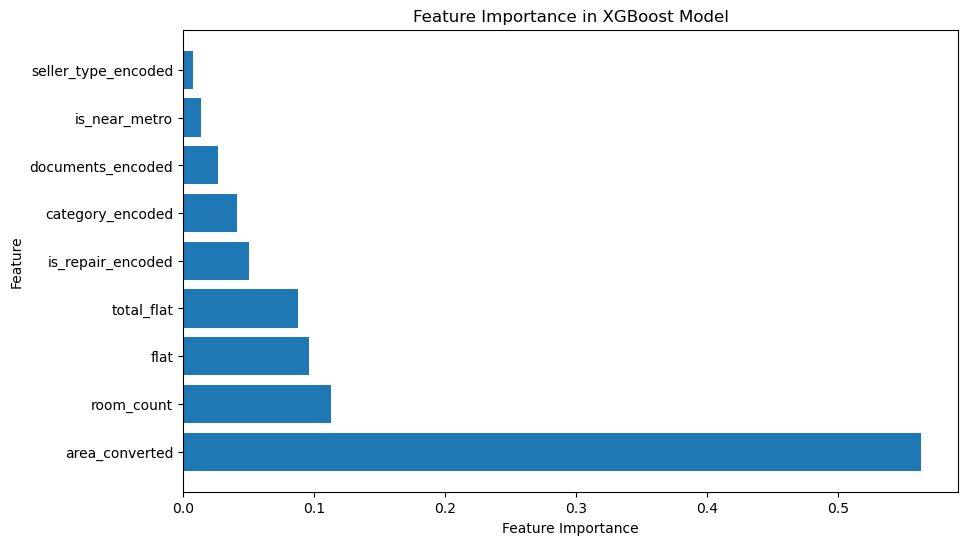

In [19]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)
top_10_feature_importance = sorted_feature_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10_feature_importance['Feature'], top_10_feature_importance['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost Model')
plt.show()